In [2]:
import numpy as np
import scipy
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
import lanczos as lz

## Part a)

Generate the Hamiltonian for L = 14 and g = 1.5 using the functions provided in
lanczos.py. Moreover, generate a random state (in the full basis), which we can use
as a starting vector for the Lanczos iteration.

In [22]:
#L = 14
#g = 1.5
L = 10
g = 1.5
H = lz.gen_hamiltonian(lz.gen_sx_list(L), lz.gen_sz_list(L), g, J=1.)

#generate random state
def prepare_randomstate(L):
    """Initialize the system."""
    state = np.random.randint(0, 2, size=(2**L))
    return state

initial_state = prepare_randomstate(L)
print(initial_state)


[1 0 1 ... 0 1 1]


## b) 
Call the function lanczos() with parameters N=200, stabilize=False. The function
returns the tridiagonal matrix T and orthonormal basis of the Krylov space generated during the Lanczos iteration. Determine the 10 smallest eigenvalues of T
using np.linalg.eigvalsh. Do you find a ground state degeneracy? Do you expect a
degeneracy for these parameters?

In [24]:
T_false, vecs_false = lz.lanczos(initial_state, H)

ten_smallest_eigenvalues = np.linalg.eigvalsh(T_false)[:10]
print(ten_smallest_eigenvalues)

[-16.72302491 -16.72302491 -16.72302491 -16.72302491 -15.71545507
 -15.71545507 -15.71545507 -15.71545507 -14.90112432 -14.90112432]


I found a ground state degeneracy which is not expected, since the model should follow a paramagnetic behaviour with no degeneracy between ground state and first excited state.

Call lanczos() again with stabilize=True. What does this option do? Do you get the
expected degeneracy now? Can you explain this? Confirm the results by comparing
with the (quasi-exact) energies returned by scipy.sparse.linalg.eigsh.

In [25]:
T_true, vecs_true = lz.lanczos(initial_state, H, stabilize = True)

"""
Stabilize = True: makes sure that new psi state obtained is orthonormal to the previously obtained psi states,
This is achieved with Gram-Schmidt orthonormalization.
Theoretically this step should not be necessary as the state should already be orthonormal by costruction,
however this makes sure that the basis obtained is orthonormal
"""
ten_smallest_eigenvalues_corrected = np.linalg.eigvalsh(T_true)[:10]
print(ten_smallest_eigenvalues_corrected)

print()

ten_eigenvalues_Sparse = scipy.sparse.linalg.eigsh(H, k = 10, which = 'SA', return_eigenvectors=True)[0]
print(ten_eigenvalues_Sparse)

[-16.72302491 -15.71545507 -14.90112432 -14.90112432 -14.20324571
 -13.66721032 -13.66721032 -13.02457488 -13.02457488 -13.02457488]

[-16.72302491 -15.71545507 -14.90112432 -14.90112432 -14.20324571
 -13.66721032 -13.66721032 -13.02457488 -13.02457488 -13.02457488]


## c)
Find the ground state |u0⟩ of T and use it to find the ground state |ψ0⟩ of H in the
full basis. Check that the state you obtain is normalized, has the correct energy
E0 = ⟨ψ0|H|ψ0⟩. Calculate the variance ⟨ψ0|H2|ψ0⟩ − ⟨ψ0|H|ψ0⟩2 to see if |ψ0⟩ is an
eigenstate of H.
Hint: Let V denote the matrix containing the vectors returned by lanczos() as
columns, then V †HV = T Hence, if |u⟩ is an eigenvector of T , |ψ0⟩ := V |u0⟩ is an
(approximate) eigenvector of H.


In [26]:
eigvalue, eigstates = np.linalg.eigh(T_true)
u_zero = eigstates[:,0]
#print(vecs_true)
#print(np.shape(vecs_true))
#print(np.shape(u_zero))
V = np.transpose(vecs_true)
groundstate = V @ u_zero
print("|ψ0⟩: ", groundstate)
print()

E_0 = np.inner(np.conj(groundstate), H*groundstate)
print("E0: ", E_0)
print()

var = np.inner(np.conj(groundstate), H*H*groundstate) - E_0**2
print("variance: ", var)

if np.abs(E_0 - ten_smallest_eigenvalues_corrected[0]) < 1e-12 and var < 1e-12:
    print("|ψ0⟩ is ground state")

|ψ0⟩:  [ 8.49147107e-01  4.38924357e-17 -2.38206586e-16 ...  1.48612764e-16
 -1.80497974e-16  3.00301445e-04]

E0:  -16.723024913948464

variance:  -6.821210263296962e-13
|ψ0⟩ is ground state


## d)
Construct the state $ |ϕ_0⟩ = S^{+}_0 |ψ_0⟩ $
and get the tridiagonal matrix T of a Lanczos
iteration starting from this initial state. Here, $S^+_j = \frac{1}{2} (σ_{x_j} + iσ_{y_j} ) $ labels the spin raising operator on site j.
Hint: To construct $S^{+}_0$, take a look at lanczos.py again.

In [27]:
Splus_0 = lz.singlesite_to_full(lz.Splus,0,L)
phi_0 = Splus_0 * groundstate

T_dynamic, vecs_dynamic = lz.lanczos(phi_0, H, stabilize = True)

T_dynamic

array([[-13.96083124,   2.22333481,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  2.22333481, -11.11914418,   2.86842105, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   2.86842105,  -9.37014001, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,  -5.56472818,
          3.9676885 ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   3.9676885 ,
          2.30906271,   6.15196117],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          6.15196117,   3.67142096]])

## e)

Write a function which (given z and T ) evaluates the continued fractions of eq. (3)
to calculate I.
Hint: You can extract α and β from T using np.diag. Take care that we labeled $α_n$
starting from n = 0 , while for βn we start from n = 1.

In [28]:
def get_I(z,T):
    alpha = np.diag(T)
    beta = np.diag(T,k=1)
    # I have to calculate x_0 = det(z-T)_1 /det(z-T), and to do it I have to do it recursively and backwards, starting from the last calculation:
    # x_0 = detD_N-1/detD_N-2
    N = len(alpha)
    x_0 = 1/(z-alpha[-2]-((beta[-1]**2)/(z-alpha[-1])))
    for i in range(N-2,0,-1): #by counting properly it is clear that we have to repeat this process N-3+1= N-2 times
        x_0 = 1/(z-alpha[i-1]-(beta[i]**2)*x_0)

    return - x_0.imag * 1/np.pi


I_example = get_I(1+E_0+1j*0.005,T_dynamic)

## f)
Plot $I(S^+_0 , ω)$ versus ω. Choose $z = ω + E_0 + iϵ$ for ω ∈ [−1, 10] and ϵ in the order
of 0.001 ≲ ϵ ≲ 0.1. What is the influence of ϵ?
Hint: There’s a good chance that the function calculating I from e) works with z
being a numpy array with different ω values; this will lead to a faster evaluation
than calling it for each ω separately.

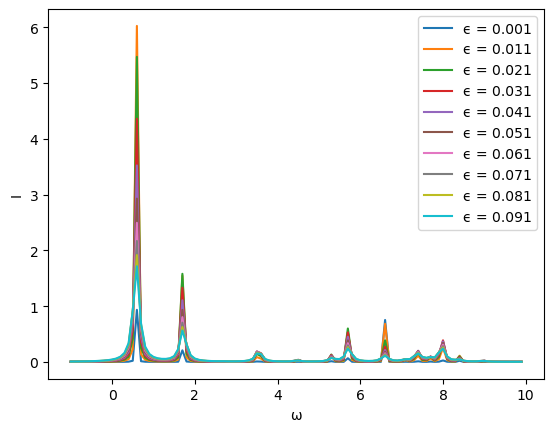

In [29]:
epsilon = np.arange(0.001,0.1,0.01)
w = np.arange(-1,10,0.1)

z = []
I = []

for i in range(len(epsilon)):
    z.append(w + E_0+ 1j*epsilon[i])
    I.append(get_I(z[i],T_dynamic))
    plt.plot(w,I[i], label = f"ϵ = {epsilon[i]:.3f}")
plt.xlabel("ω")
plt.ylabel("I")
plt.legend()

The smaller the epsilon the more peaked is I  

## g)
To get more physical insight, we can choose a momentum-dependent operator for $\hat{O}$. Calculate $I(S^+_k , ω)$ for the k values compatible with the chosen L = 14, where $S^+_k$ is defined as
$$S^+_k = \frac{1}{\sqrt{L}} \sum^{L-1}_{j=0}{e^{ijk}S^+_j} \hspace{3cm} (5)$$
Create a 2D colorplot of $I(S^+_k , ω)$ with k on the x-axis and ω on the y-axis.

Hint: To create the colorplot, you can use the function provided in lanczos.py.

*The compatible k values are given by the periodic boundary conditions of the lattice: $k \in [-\frac{\pi}{a},\frac{\pi}{a}] \; \leftrightarrow k = \frac{s 2\pi}{a}$ with $s = -\frac{L}{2},-\frac{L}{2} +1, ..., \frac{L}{2} $*

*Here actually a = 1, and we can also choose $k = 0,...,2\pi \frac{L-1}{L}$*


In [34]:
#k = np.arange(0,2*np.pi, 2*np.pi/L)
k = np.arange(-L//2, L/2+0.5, 1.) * (2*np.pi)/L 


S_moment= []
I_moment = []

for i in range(len(k)):
  S = 0
  for l in range(L):
    S += np.exp(1j*l*k[i])*lz.singlesite_to_full(lz.Splus,l,L)
  S = S/np.sqrt(L)
  S_moment.append(S)
  phi_moment = S * groundstate
  T_moment = lz.lanczos(phi_moment, H, stabilize = True)[0]
  I_moment.append(get_I(z[0],T_moment))
I_moment = np.array(I_moment)

#we are interested in z[0] (the one with epsilon = 0.001, omega from -1 to 10)
    

In [35]:
I_moment[0][2]
#first index referred to k, second to w

9.590198968092973e-06

<>:3: SyntaxWarning: invalid escape sequence '\o'
<>:3: SyntaxWarning: invalid escape sequence '\o'
/var/folders/j2/38n83hh910154cw8rylx28rh0000gq/T/ipykernel_71615/1935082199.py:3: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("$\omega $")


Text(0.5, 1.0, '$I(S^+_k , ω)$')

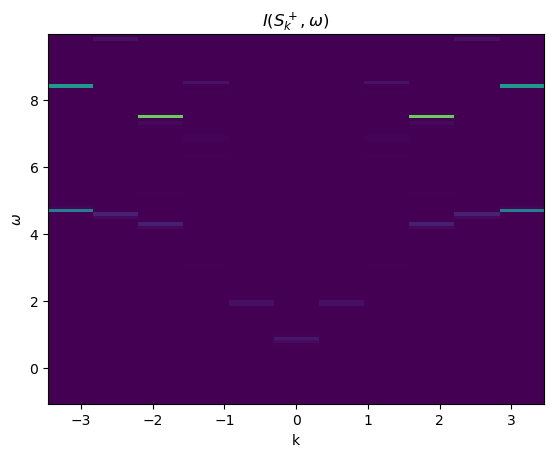

In [37]:
lz.colorplot(k,w,I_moment)
plt.xlabel("k")
plt.ylabel("$\omega $")
plt.title("$I(S^+_k , ω)$")